# Analysis of songs and their lyrics

## Installation and loading of libraries
``` 
$ pip3 install top2vec
$ pip3 install spacy
$ [Installeren van Nederlands voor Spacy]
```

In [55]:
from top2vec import Top2Vec

import os
import spacy
import unidecode

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Data and sources


## Prints for Koppermaandag
From the 18th century onwards, so called "Koppermaandagprenten" are retained in cultural heritage institutes. These prints are a proof of the quality of printing that a printshop was able to deliver. The labourers of a printshop made a print and brought them to the customers, expecting them to buy the print, or give a tip. This extra income was used to buy drinks on "Koppermaandag", a celebration on the first Monday after Epiphany.

In 199?, an important publication is made about this type of printwork, with an overview of the retained Koppermaandagprenten. From this book the counts per year are available.

In [56]:
prentenDF = pd.read_csv("data/koppermaandagprentenCount.csv", index_col="year")

# TODO: Hoeveel prenten zijn er in totaal overgeleverd?

## Data about songs
Between 1848 and ca. 1914 typographical associations created booklets with lyrics of songs they sang during feasts they organized. The dataset contains a table (in CSV) with an overview of all the songs in the booklets between 1848 and 1870, with among others title, year and writer.

In [57]:
liedjesDF = pd.read_csv("data/liedjes.csv", dtype={'jaartal': 'Int32'})

print("Number of songs:    " + str(len(liedjesDF)))
print("Number of booklets:  " + str(len(liedjesDF['sourceID'].unique())))

Number of songs:    729
Number of booklets:  59


## Song lyrics from files
Besides the overview of the songs in a CSV-file, for every song there is a machine readable representation of the lyrics. We use the following functions to process them.

In [58]:
def getlistOfFilenames(rootdir):
    # input: rootdir: directory with (subdirectory with) TXT-files to be handled
	# output: list of TXT-files(+path) lexicographically ordered on path-name

    files_all = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            if not file.endswith('.txt'):
                continue
            fn = os.path.join(subdir, file)
            files_all.append(fn)

    files_all = sorted(files_all)
    return files_all

def getlistOfTexts(listOfFilenames):
	# input: listOfFilenames: list of TXT-files(+path) lexicographically ordered on path-name
    # output: list of texts

	texts = []
	for file in listOfFilenames:
		with open(file) as stream:
			text = stream.read()
		texts.append(text)

	return texts

def lemmatize(listOfTexts, select = True, allowed_postags=["NOUN", "ADJ", "ADV", "VERB"]):   
    # input: listOfTexts: list of Dutch texts
    # input: allowed_postags: list of wordtypes to be kept in the lemmatization process
    # output: list of lemmatized Dutch texts (list of lists of words). Lemmatization by spaCy.

    nlp = spacy.load("nl_core_news_sm") # create spaCy processor named 'nlp' based on small model for Dutch

    result = []                                                         
    for text in listOfTexts:                                                     

        nlp.max_length = len(text)  
        doc = nlp(text) # tokenize and annotate 'text' with processor named 'nlp'

        new_text = []
        for token in doc: 
            if token.is_alpha: # keep tokens with alphanumerical characters (so no numbers or punctuation)
                if not token.is_stop: # remove stopwords
                    if select:
                            if token.pos_ in allowed_postags: # keep wordtypes in the allowed_postags list
                                new_text.append(unidecode.unidecode(token.lemma_)) # get the word in the lemma and add it to the list of words
                    else: new_text.append(unidecode.unidecode(token.lemma_))

        result.append(new_text) # add list-of-words to the list of lemmatized texts

    return result
    
def replace(listOfWords, replaceWords):
    # input: listOfWords
    i = 0
    for word in listOfWords:
        if word in replaceWords:
            listOfWords[i] = replaceWords[word]
        i = i + 1

    return listOfWords

def remove(listOfWords, removeWords):
    i = 0
    for word in listOfWords:
        if word in removeWords:
            listOfWords.pop(i)
        i = i + 1

    return listOfWords

def preprocess(listOfWordlists, replaceDict, removeList):
    result = []
    for liedje in listOfWordlists:
        preprocessedLiedje = " ".join(remove(replace(liedje, replaceDict), removeList))
        result.append(preprocessedLiedje)

    return result

We use the above functions to read the lyrics.

In [75]:
liedjesFilenames    = getlistOfFilenames('data/lyrics')  # results into list of strings
liedjes             = getlistOfTexts(liedjesFilenames)   # results into list of strings
lemmatizedLiedjes   = lemmatize(liedjes, select = False) # results into list of lists of words

replaceDict = {"koster":"coster", "costers":"coster", "kosters":"coster", "vreugd":"vreugde", "blijd":"blijde"}
removeList  = ["ha", "deez", "zoo", "hoezee", "tra", "la", "li", "eene", "gaan", "komen", "laten", "weer", "vinden", "uw", "staan", "waarmee", "immer", "t", "d", "wijze", "hurah"]

preprocessedLiedjes = preprocess(lemmatizedLiedjes, replaceDict, removeList) # list of strings

To investigate whether our code has worked, we look at songs with number ```n```.

In [84]:
n = 4
print(liedjesDF.iloc[n])
print(liedjesFilenames[n])
print(liedjes[n])
print(lemmatizedLiedjes[n])
print(preprocessedLiedjes[n])


typoID                                            NaN
sourceID                                 liederen1863
songID                             ??-liederen1863-04
titel                   Weinig maar uit een goed hart
wijze                            Wien Neerlands bloed
jaartal                                          1863
schrijver                               P. Werthweijn
vereniging_schrijver                  amsterdam1857-1
wordcount                                         103
topic                                               0
topic_score                                   0.98347
Name: 4, dtype: object
data/lyrics/??-liederen1863/??-liederen1863-04.txt
Weinig maar uit een goed hart

't Is feest, 't is feest in Amsterdams,
Gevierd door d'ambachtstand;
Gewijd aan d’ eedlen Nassau's-stam,
Den Redder van het land;
't Verlossingswerk, vóór vijftig jaar
Met Willem Een verrigt,
Verdreef van hier den adelaar,
Zoo listig afgerigt.

De drukpers-vrijheid wordt herdacht
Die ons Oranje schon

# Count 
The development of the number of particular retained heritage of printing in the nineteenth century might say something about the change of relevance for printers to create these prints. In this notebook the development of printing heritage is investigated.



## Number of Koppermaandagprenten per year
First, we study the number of Koppermaandagprenten per year. We smooth the count with a five year rolling mean. We observe two timeperiods where the making of these prints was popular: the 1820's and between 1840-1860.

<AxesSubplot: xlabel='year'>

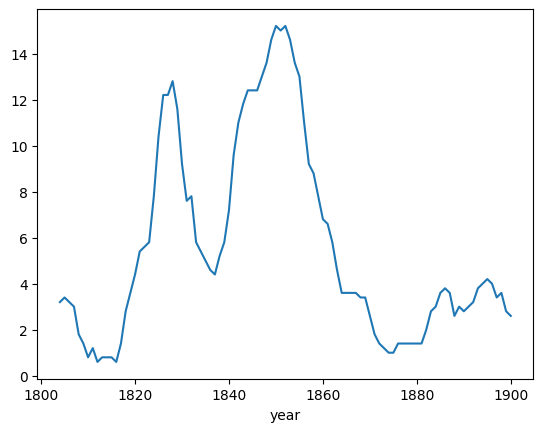

In [61]:
prentenDF['count'].rolling(5).mean().plot()

## Number of songs and number of words per year
Secondly, we want to investigate how much songs are in the dataset per year. We smooth the outcome again with a five years rolling mean. We observe a popularity for creating songs between 1850 en 1865.

<AxesSubplot: xlabel='jaartal'>

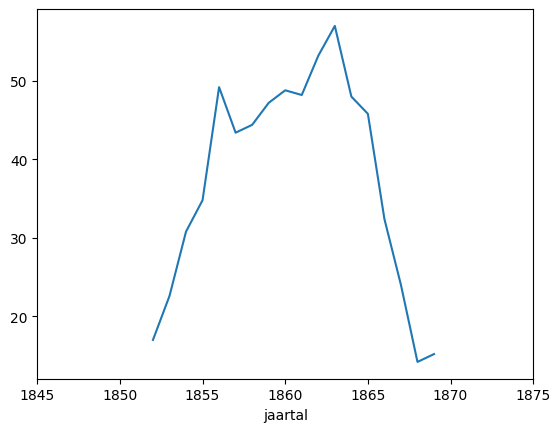

In [62]:
liedjesDF.groupby('jaartal').size().rolling(5).mean().plot(xlim=(1845,1875))

We study the number of words per year, instead of the number of songs per year for a potentially more precise indication. We calculate the number of words per song and add this to the liedjes DataFrame.

(array([ 0.,  0.,  2.,  3.,  3.,  3.,  8., 17., 18., 39., 25., 56., 65.,
        75., 56., 45., 39., 40., 42., 31., 28., 23., 15., 23., 18., 14.,
         6.,  6.,  6.,  6.,  2.,  2.,  1.,  3.,  2.,  1.,  1.,  0.,  0.]),
 array([  0.,   5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,
         55.,  60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100., 105.,
        110., 115., 120., 125., 130., 135., 140., 145., 150., 155., 160.,
        165., 170., 175., 180., 185., 190., 195.]),
 <BarContainer object of 39 artists>)

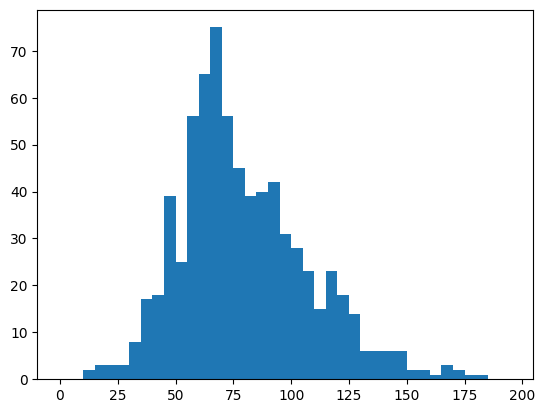

In [63]:
numberOfSongs = len(liedjes)
listOfWordcounts = []
for i in range(0,numberOfSongs): listOfWordcounts.append(len(lemmatizedLiedjes[i]))

plt.hist(listOfWordcounts, bins=range(0,200,5), range=[0,200])


In [64]:
liedjesDF['wordcount'] = listOfWordcounts
liedjesDF.iloc[n]


typoID                                       amsterdam1849
sourceID                   amsterdam1849-feestliederen1862
songID                  amsterdam1849-feestliederen1862-02
titel                                               Welkom
wijze                                    Henri's drinklied
jaartal                                               1862
schrijver                                     H. Regenboog
vereniging_schrijver                         amsterdam1849
wordcount                                               72
Name: 160, dtype: object

<AxesSubplot: xlabel='jaartal'>

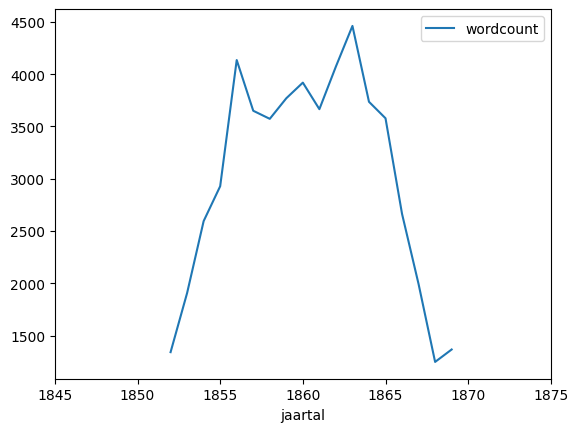

In [65]:
liedjesDF.groupby('jaartal').sum('wordcount').rolling(5).mean().plot(xlim=(1845,1875))

## Average size of a song per year
So the number of songs and the total number of words in the lyrics per year does not differ that much. How about the average size of a song per year? 

<AxesSubplot: xlabel='jaartal'>

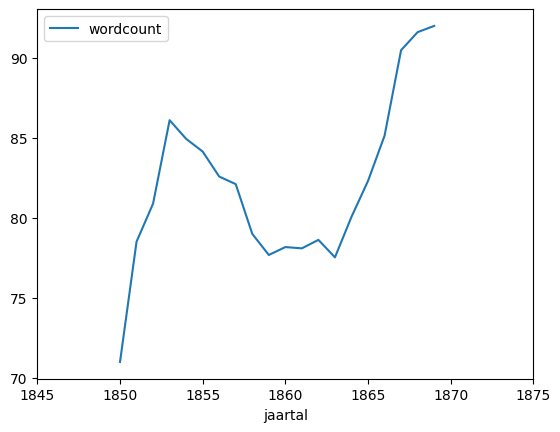

In [66]:
liedjesDF.groupby('jaartal').mean('wordcount').rolling(3).mean().plot(xlim=(1845,1875))

## Number of booklets per year
The number of booklets per year 

<AxesSubplot: xlabel='year'>

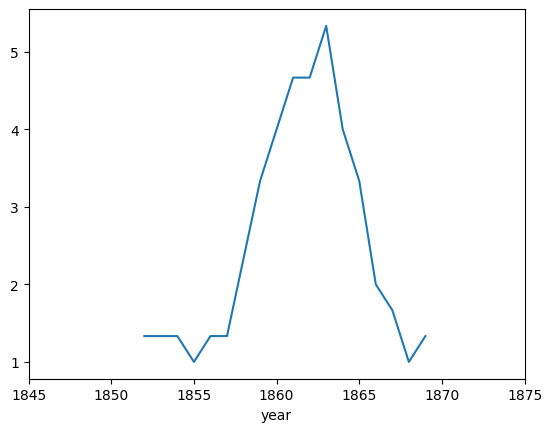

In [67]:
boekjesDF    = pd.read_csv('data/boekjes.csv')
boekjesSlice = boekjesDF.loc[boekjesDF['size'] < 50].loc[boekjesDF['size'] > 2]
boekjesSlice.groupby('year').size().rolling(3).mean().plot(xlim=(1845,1875))

## Average size of booklets per year, in number of songs and number of words

# Topics with Top2Vec
Do the topics of songs change over time?

In [105]:
joinedLiedjes = []
for liedje in lemmatizedLiedjes:
    joinedLiedje = " ".join(liedje)
    joinedLiedjes.append(joinedLiedje)

model = Top2Vec(preprocessedLiedjes)

2022-12-27 17:00:04,556 - top2vec - INFO - Pre-processing documents for training
2022-12-27 17:00:04,673 - top2vec - INFO - Creating joint document/word embedding
2022-12-27 17:00:06,034 - top2vec - INFO - Creating lower dimension embedding of documents
2022-12-27 17:00:12,953 - top2vec - INFO - Finding dense areas of documents
2022-12-27 17:00:12,966 - top2vec - INFO - Finding topics


In [106]:
model.topic_sizes

0    614
1    115
dtype: int64

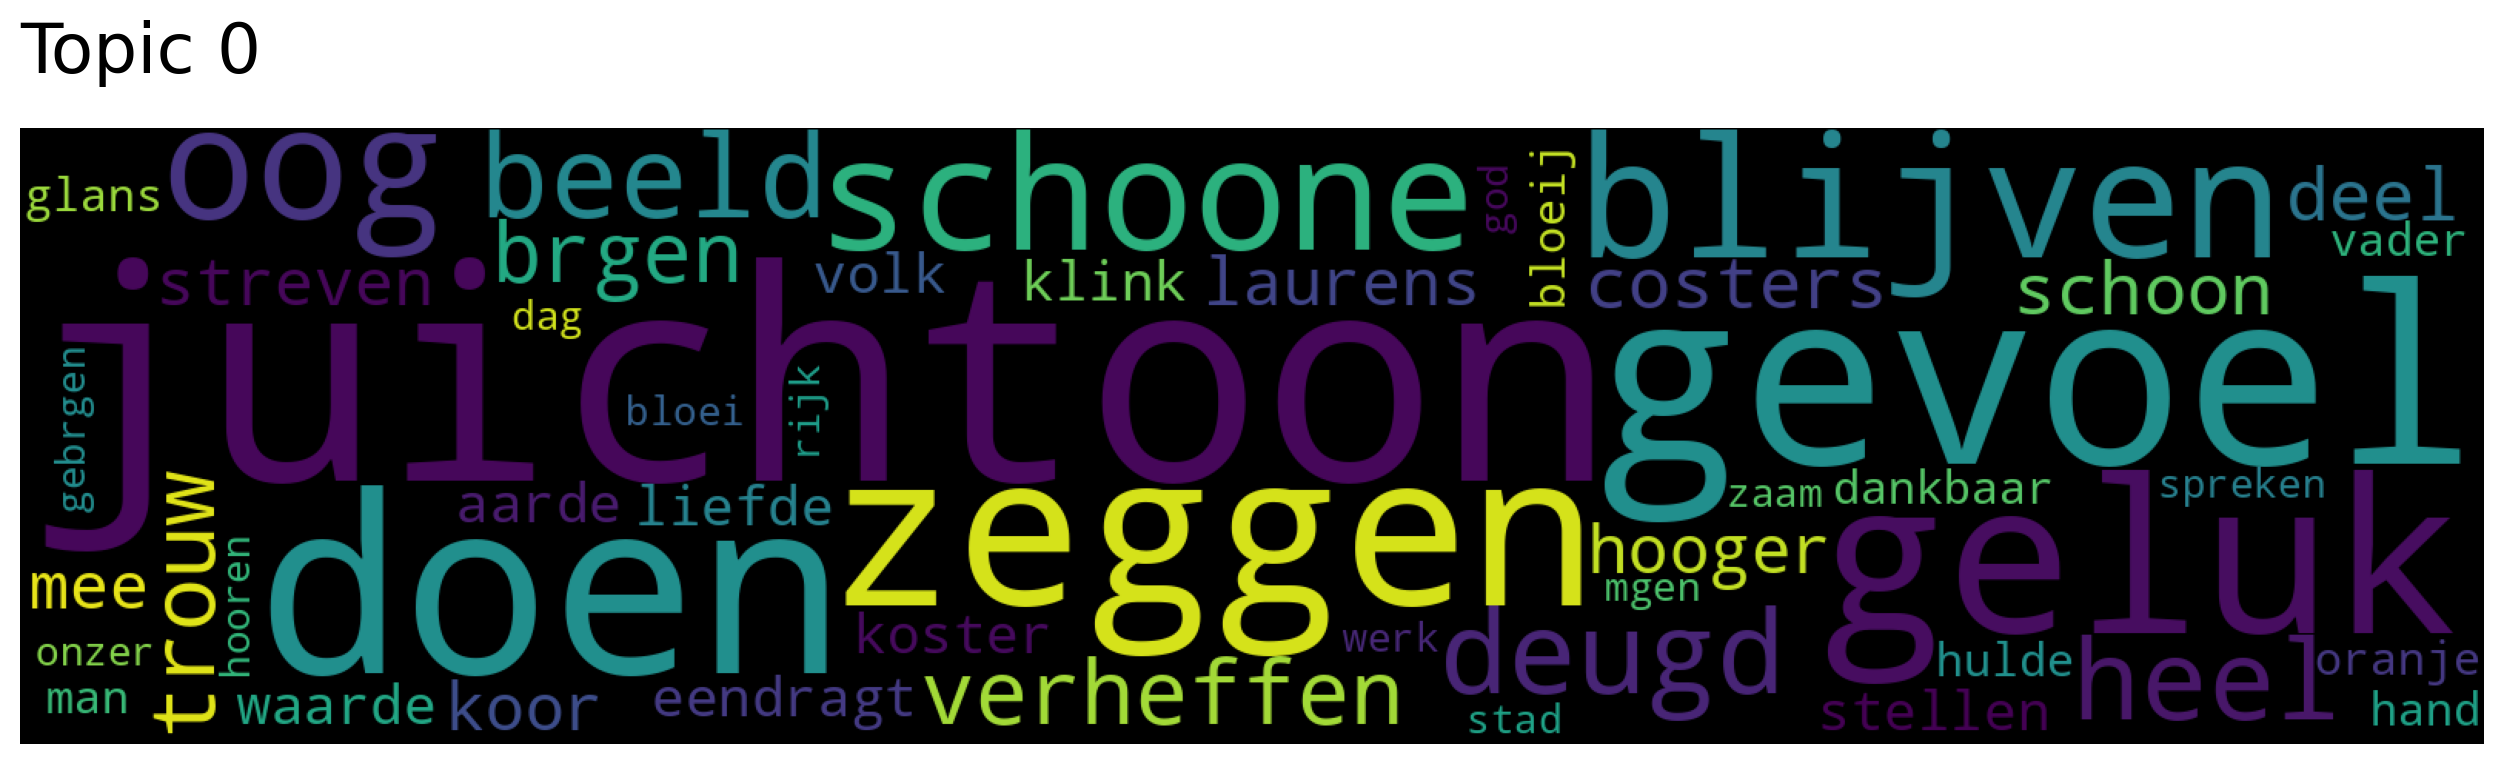

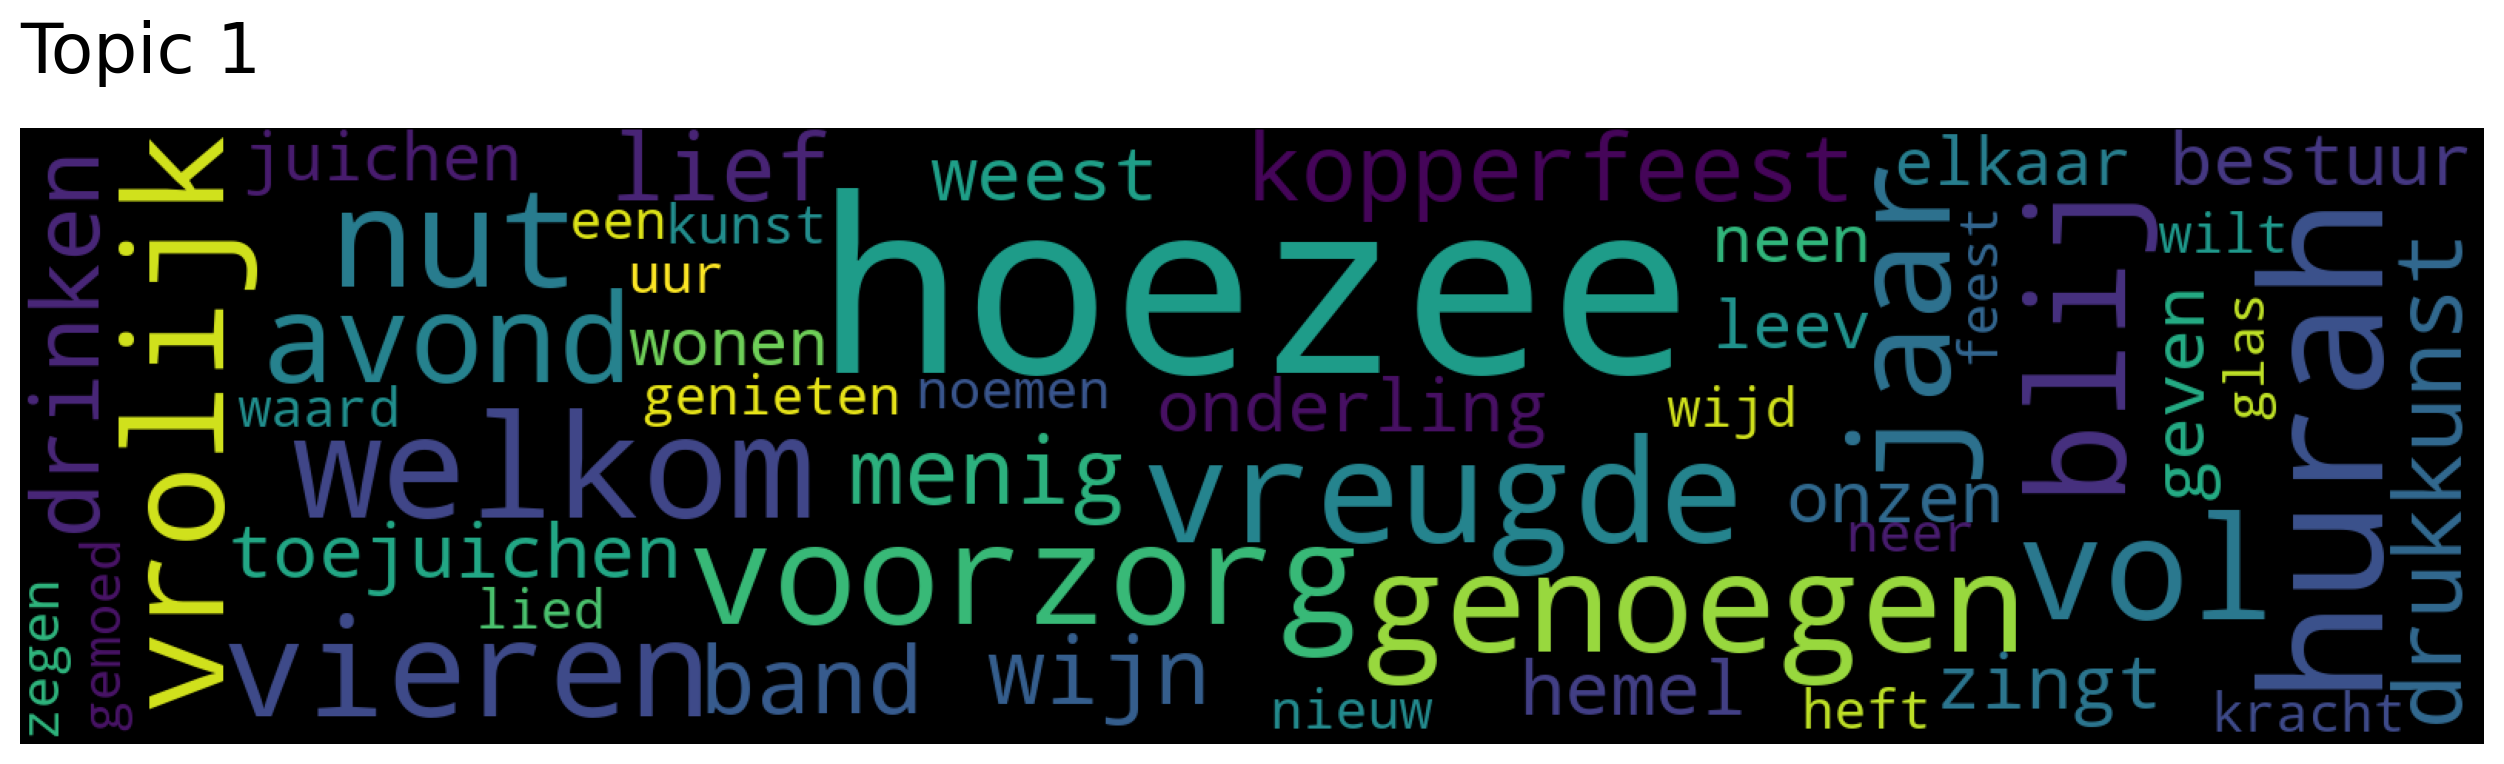

In [107]:
topic_sizes, topic_nums = model.get_topic_sizes()
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [108]:
documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=["wijn", "glas"], num_docs=3)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")

Document: 110, Score: 0.9870209693908691
Document: 179, Score: 0.985748827457428
Document: 465, Score: 0.9846316576004028


In [109]:
model.get_documents_topics([n])

(array([0]),
 array([0.98414004], dtype=float32),
 array([['juichtoon', 'gevoel', 'doen', 'zeggen', 'geluk', 'blijven',
         'schoone', 'oog', 'deugd', 'beeld', 'heel', 'verheffen', 'trouw',
         'brgen', 'schoon', 'costers', 'deel', 'hooger', 'laurens',
         'koor', 'streven', 'mee', 'eendragt', 'koster', 'waarde',
         'stellen', 'liefde', 'klink', 'aarde', 'volk', 'oranje', 'man',
         'bloeij', 'dankbaar', 'vader', 'glans', 'hulde', 'hand',
         'spreken', 'stad', 'gebrgen', 'zaam', 'onzer', 'dag', 'bloei',
         'werk', 'mgen', 'god', 'rijk', 'hooren']], dtype='<U11'),
 array([[0.9963919 , 0.9961655 , 0.9960929 , 0.995647  , 0.9951986 ,
         0.9950911 , 0.9949305 , 0.9949188 , 0.9949016 , 0.9948859 ,
         0.9948527 , 0.9945665 , 0.9945389 , 0.9945346 , 0.9943633 ,
         0.9942071 , 0.99418527, 0.9941659 , 0.99408156, 0.99403065,
         0.9938438 , 0.99379593, 0.99373466, 0.99361223, 0.9933564 ,
         0.99303335, 0.9929712 , 0.99278694, 0.

In [110]:
doc_ids = list(range(0, 729))
topics, topic_scores, topic_words, words_score = model.get_documents_topics(doc_ids)

liedjesDF['topic'] = topics
liedjesDF['topic_score'] = topic_scores

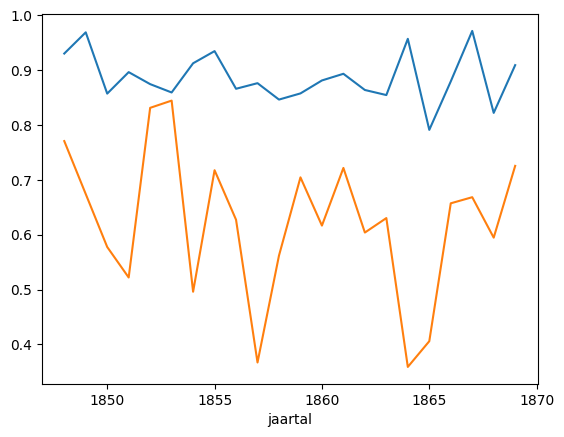

In [111]:
for topic in topic_nums:
    df = liedjesDF.loc[liedjesDF.topic == topic]
    dfAvg = df.groupby('jaartal').mean('topic_score')
    dfAvg['topic_score'].plot()
